<a href="https://colab.research.google.com/github/pszachew/Delivery-Prediction/blob/master/DataPreprocessing_3classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns
import joblib

In [26]:
def get_preprocess():
  deliveries = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/deliveries.jsonl', lines=True)
  sessions = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/sessions.jsonl', lines=True)
  products = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/products.jsonl', lines=True)
  users = pd.read_json('https://raw.githubusercontent.com/pszachew/Delivery-Prediction/master/data_v2/users.jsonl', lines=True)
  ls=['monday', 'tuesday','wednesday', 'thursday', 'friday', 'saturday', 'sunday']
  deliveries['delivery_timestamp'] = deliveries['delivery_timestamp'].apply(lambda x: pd.to_datetime(x))
  deliveries['delivery_weekday'] = deliveries['delivery_timestamp'].apply(lambda x: ls[x.weekday()])
  deliveries['delivery_day'] = deliveries['delivery_timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
  deliveries['purchase_timestamp'] = deliveries['purchase_timestamp'].apply(lambda x: pd.to_datetime(x))
  deliveries['purchase_weekday'] = deliveries['purchase_timestamp'].apply(lambda x: ls[x.weekday()])
  deliveries['purchase_day'] = deliveries['purchase_timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
  deliveries['diff_days'] = (deliveries['delivery_day'] - deliveries['purchase_day']).apply(lambda x: x.days)
  tmp = deliveries['diff_days']
  deliveries['purchase_morning'] = deliveries['purchase_timestamp'].apply(lambda x: 1 if x.hour<=14 else 0)
  all_info = deliveries.merge(sessions.merge(products, on='product_id', how='left'), on='purchase_id', how='left')
  all_info = all_info.merge(users, on='user_id', how='left')
  dec_var = ["delivery_company", 'diff_days', 'purchase_morning', 'city', 'purchase_weekday']
  all_info = all_info.drop(all_info.index[all_info['diff_days'].isin([0,5])], axis=0)
  all_info = all_info[dec_var]
  city_dum = pd.get_dummies(all_info['city'], drop_first=True)
  weekday_dum = pd.get_dummies(all_info['purchase_weekday'], drop_first=True)
  delivery_company_dum = pd.get_dummies(all_info['delivery_company'], drop_first=True)
  delivery_company_dum = delivery_company_dum.rename(columns={360:'delivery_360', 254:'delivery_254', 516:'delivery_516', 620:'delivery_620'})
  all_info.drop('delivery_company', axis=1, inplace=True)
  all_info.drop('city', axis=1, inplace=True)
  all_info.drop('purchase_weekday', axis=1, inplace=True)
  final = pd.concat([all_info, city_dum, delivery_company_dum, weekday_dum], axis=1)
  return final.drop('diff_days', axis=1), final['diff_days'], tmp

## **Przewidywanie 4 klas. Dni ze zbioru {1,2,3,4}**

In [3]:
X, y, tmp = get_preprocess()
#y = y.apply(lambda x: 3 if x>3 else x)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


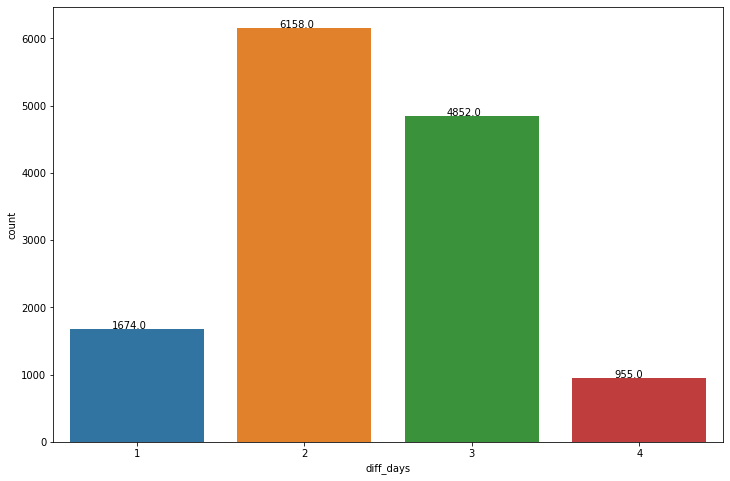

In [4]:
plt.figure(figsize=(12,8))
ax = sns.countplot(y)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.show()

In [5]:
X

,purchase_morning,Kraków,Poznań,Radom,Szczecin,Warszawa,Wrocław,delivery_360,delivery_516,delivery_620,monday,saturday,sunday,thursday,tuesday,wednesday
0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
4,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13755,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
13756,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
13757,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
13758,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


## **Logistic Regression**

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [8]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pre = model.predict(X_test)
print(accuracy_score(y_test, y_pre))
print(classification_report(y_test, y_pre))

0.7433903576982893
              precision    recall  f1-score   support

           1       0.74      0.58      0.65       556
           2       0.72      0.80      0.76      2028
           3       0.77      0.76      0.77      1611
           4       0.79      0.55      0.65       306

    accuracy                           0.74      4501
   macro avg       0.76      0.67      0.71      4501
weighted avg       0.75      0.74      0.74      4501



In [9]:
cm = confusion_matrix(y_test, y_pre)

In [10]:
print(cm)

[[ 323  202   31    0]
 [  87 1624  272   45]
 [  24  356 1231    0]
 [   0   73   65  168]]


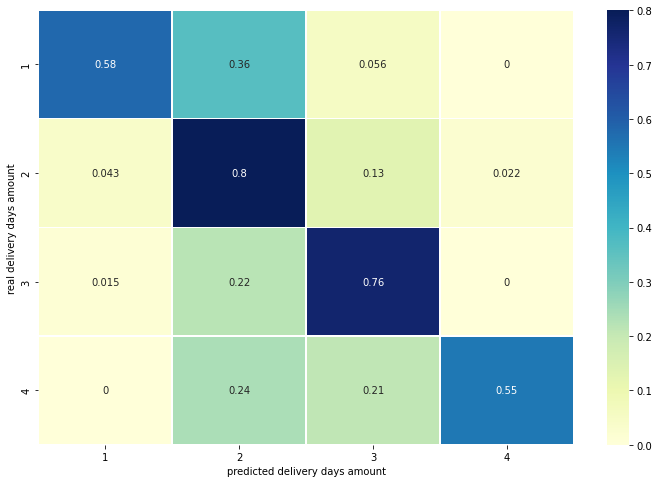

In [11]:
cm2 = confusion_matrix(y_test, y_pre, normalize='true')
cm2 = pd.DataFrame(cm2, index=[1,2,3,4], columns=[1,2,3,4])
plt.figure(figsize=(12,8))
sns.heatmap(cm2, annot=True, linewidths=.5, cmap="YlGnBu")
plt.xlabel("predicted delivery days amount")
plt.ylabel("real delivery days amount")
plt.show()

Dostawy, które zajęły 4 dni nie są zbyt dobre - połowa z nich faktycznie zostanie dostarczona po 4 dniach, a cała reszta rozłoży się równomiernie dla 2 i 3 dni. Najlepszym sposobem jest połączenie klasy 4 z 3 - wówczas 3 dni będzie oznaczało, że 3 lub 4.

## **Przewidywanie 3 klas - dni ze zbioru {1,2,3}**

## **Pierwszy model Regresja Logistyczna**

In [27]:
X, y, tmp = get_preprocess()
y = y.apply(lambda x: 3 if x>3 else x)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pre = model.predict(X_test)
print(accuracy_score(y_test, y_pre))
print(classification_report(y_test, y_pre))

0.7573872472783826
              precision    recall  f1-score   support

           1       0.74      0.58      0.65       556
           2       0.72      0.80      0.76      2028
           3       0.81      0.76      0.78      1917

    accuracy                           0.76      4501
   macro avg       0.76      0.71      0.73      4501
weighted avg       0.76      0.76      0.76      4501



In [15]:
cm = confusion_matrix(y_test, y_pre)

In [16]:
print(cm)

[[ 323  201   32]
 [  87 1622  319]
 [  24  429 1464]]


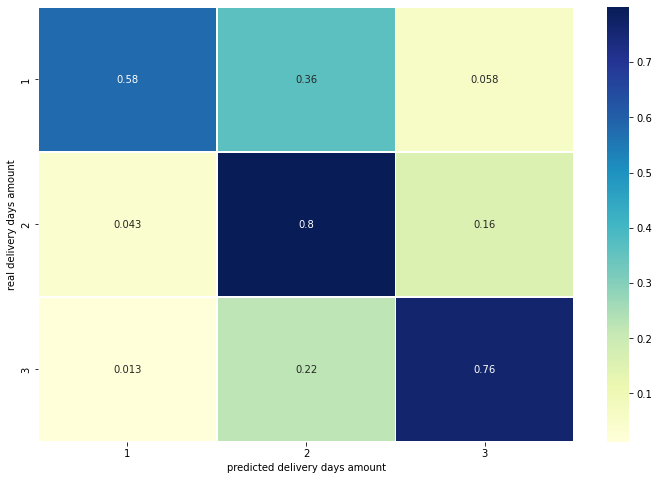

In [17]:
cm2 = confusion_matrix(y_test, y_pre, normalize='true')
cm2 = pd.DataFrame(cm2, index=[1,2,3], columns=[1,2,3])
plt.figure(figsize=(12,8))
sns.heatmap(cm2, annot=True, linewidths=.5, cmap="YlGnBu")
plt.xlabel("predicted delivery days amount")
plt.ylabel("real delivery days amount")
plt.show()

In [19]:
joblib.dump(model, "logiscit_regression.sav")

['logiscit_regression.sav']

Na powyższym diagramie widać, że model jest w stanie przewidywać dzień dostawy z dokładnością oscylującą w okolicach 80% dla dwóch i trzech dni. Dla dostaw trwających 1 dzień ta dokładność była mniejsza i wynosiła jedynie 58%.

Warto tutaj zwrócić uwagę, że różnica pomiędzy predykcją, a rzeczywistym czasem dostawy w praktyce nie przekracza jednego dnia.

# Walidacja Krzyżowa Regresji Logistycznej

In [21]:
from sklearn.model_selection import StratifiedKFold

In [44]:
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
for train_index, test_index in skf.split(X, y): 
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  model = LogisticRegression()
  model.fit(X_train, y_train)
  y_pre = model.predict(X_test)
  print(f"Dokładność modelu: {accuracy_score(y_test, y_pre)}")

Dokładność modelu: 0.7521994134897361
Dokładność modelu: 0.7576979472140762
Dokładność modelu: 0.7598973607038123
Dokładność modelu: 0.7521994134897361
Dokładność modelu: 0.7447744774477447


Walidacja krzyżowa 5 krotna udowodniła, że model jest "stabilny" a otrzmane wyniki nie są korzystnym wylosowaniem przypadków testowych.

## **MLPClassifier**

In [38]:
from sklearn.neural_network import MLPClassifier

In [ ]:
X, y, tmp = get_preprocess()
y = y.apply(lambda x: 3 if x>3 else x)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
MLPclass = MLPClassifier(hidden_layer_sizes=(16,16), random_state=8, activation='relu')
MLPclass.fit(X_train, y_train)
y_pred = MLPclass.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.77      0.63      0.69       556
           2       0.75      0.82      0.78      2028
           3       0.83      0.78      0.80      1917

    accuracy                           0.78      4501
   macro avg       0.78      0.75      0.76      4501
weighted avg       0.78      0.78      0.78      4501



In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 352,  170,   34],
       [  86, 1662,  280],
       [  22,  393, 1502]])

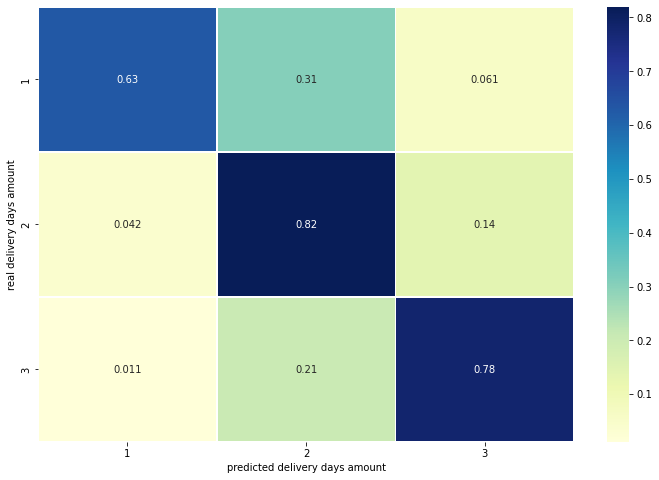

In [ ]:
cm2 = confusion_matrix(y_test, y_pred, normalize='true')
cm2 = pd.DataFrame(cm2, index=[1,2,3], columns=[1,2,3])
plt.figure(figsize=(12,8))
sns.heatmap(cm2, annot=True, linewidths=.5, cmap="YlGnBu")
plt.xlabel("predicted delivery days amount")
plt.ylabel("real delivery days amount")
plt.show()

Na powyższym diagramie przedstawiającym wyniki dla modelu MLP widać, że model jest w stanie przewidywać dzień dostawy z dokładnością oscylującą w okolicach 80% dla dwóch i trzech dni. Dla dostaw trwających 1 dzień ta dokładność była mniejsza i wynosiła jedynie 63%.

Różnica pomiędzy predykcją, a rzeczywistym czasem dostawy w praktyce nie przekracza jednego dnia.

Wyniki otrzymane przez MLP są lepsze od wyników regresji dla każdego z przypadków.
Jest to wytłumaczalne, gdyż regresja logistyczna jest podzbiorem sieci MLP.

# Walidacja Krzyżowa Sieci MLP

In [36]:
from sklearn.model_selection import StratifiedKFold

In [43]:
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
for train_index, test_index in skf.split(X, y): 
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  MLPclass = MLPClassifier(hidden_layer_sizes=(16,16), random_state=8, activation='relu')
  MLPclass.fit(X_train, y_train)
  y_pred = MLPclass.predict(X_test)
  print(f"Dokładność modelu: {accuracy_score(y_test, y_pred)}")

Dokładność modelu: 0.7782258064516129
Dokładność modelu: 0.7892228739002932
Dokładność modelu: 0.7855571847507331
Dokładność modelu: 0.7774926686217009
Dokładność modelu: 0.768976897689769


Walidacja krzyżowa 5 krotna udowodniła, że model jest "stabilny" a otrzmane wyniki nie są korzystnym wylosowaniem przypadków testowych.